###  Įterpiamos reikiamos bibliotekos:

In [453]:
%matplotlib inline

import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.axes as ax

###  Dirbtinis neuronas

Pagrindinė funkcija svoriams gauti - `get_weights(...)`.


`weights` generuojami atsitiktinai iš duoto intervalo. Jei randamas toks svorių rinkinys,
kur su visomis įvestimis prognozės atitinka norimas išvestis, programa ciklas nutraukiamas ir
funkcija grąžina to rinkinio reikšmes.

### Duomenų užkrovimo modulis
Klasė `DataModule` skirta užkrauti duomenims iš failo. 

`feature_range` nurodo, kuriuos bruožus įtraukti į rinkinį.
Pavyzdžiui, jei identifikacijos numeris yra pirmas bruožas, norėsime jį išmesti.


`target_index` žymi trokštamos reikšmės indeksą failo eilutėje.


`split_rate` - nurodo, kurią dalį sudarys treniravimo duomenys. Likę duomenys bus skirti validavimui.

Pastaba: duomenų tvarka yra išmaišoma nei yra faile. Kad išmaišymas visada būtų vienodas, naudojama `np.random.seed(1)`.

In [454]:
class DataModule():
    def __init__(self, feature_range, target_index,
                 filepath, split_rate = 0.8):
        self.feature_count = feature_range[1] - feature_range[0]
        
        with open(filepath) as file:
            raw_data = [line.rstrip().split(",") for line in file]
            
        raw_data = np.array(raw_data)
        
        np.random.seed(1)
        np.random.shuffle(raw_data)
        np.random.seed()
    
        self.features = raw_data[:, feature_range[0] : feature_range[1]].astype(np.float32)
        self.targets = raw_data[:, target_index].astype(np.float32)
        
        self.training_count = int(len(raw_data) * split_rate)
      
        
    def get_training_data(self):
        return self.features[:self.training_count], self.targets[:self.training_count]
    
    
    def get_validation_data(self):
        return self.features[self.training_count:], self.targets[self.training_count:]

#### Aktyvacijos funkcijos

In [455]:
def binary_step_function(value) -> int:
    return 1 if value >= 0 else 0

def sigmoid_step_function(value) -> int:
    return 1 / (1 + np.exp(-1 * value))

### Modelis(Perceptronas)

Nurodoma aktyvacijos funkcija, kurią naudos modelis (naudoti apibrėžtas pavyzdyje).

`num_inputs` - žymi požymių skaičių. Atitinkamai tiek pat bus sugeneruotų svorių reikšmių, atsitiktinai
pagal Gauso skirstinį su iš anksto numatytom reikšmėm `mean` = 0 ir `sd` = 1.

`learning_rate` - kontroliuoja mokymosi greitį.

`adjust_weights(...)` - naudojama ADALINE mokymo taisyklė.

In [456]:
class Perceptron():
    def __init__(self, /,
                 activation_function: Callable[[list[float], list[float]], int],
                 num_inputs: int, learning_rate: float,
                 mean = 0, sd = 1):
        self.weights = np.random.normal(mean, sd, num_inputs)
        self.bias = np.random.normal(mean, sd, 1)[0]
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        
        print('Pradiniai svoriai: ', self.weights, '\n', "Pradinis poslinkis: ", self.bias)
    
    
    def forward(self, features):
        lin_regression = np.dot(self.weights, features) + self.bias
        return self.activation_function(lin_regression)
    
    
    def adjust_weights(self, features, target, prediction):
        self.weights += self.learning_rate * features * (target - prediction)
        self.bias += self.learning_rate * (target - prediction)
    
    
    def loss(self, targets, predictions):
        return(targets - predictions) ** 2 / 2
    
    
    def __call__(self, features):
        return self.forward(features)

### Treniravimo klasė
Klasė, kuri skirta treniruoti modelį, braižyti grafiką ir skaičiuoti elementarias statistikas. 

Mokymas vyksta `fit_epoch(...)` funkcijoje, pasitelkiant `model.adjust_weights(...)` aprašytą aukščiau.

In [457]:
class Trainer():
    def __init__(self) -> None:
        self.figure, self.axis = plt.subplots(2,2, figsize=(14,6))
        
        plt.subplots_adjust(
           left=0.1,
           bottom=0.1,
           right=0.9,
           top=0.9,
           wspace=0.2,
           hspace=0.6)
        

        for axis in self.axis.flat:
            axis.set(xlabel= 'Epochų skaičius', ylabel= 'Reiškmė')
    
        self.training_accuracies = []
        self.training_losses = []
        self.validation_accuracies = []
        self.validation_losses = []
        self.epochs = []


    def is_equal(self, target, prediction):
        prediction = 1 if prediction >= 0.5 else 0
        return target == prediction 
    
    def draw_graphs(self, accuracy, loss, train):
        axis = self.axis
        
                
        if train:
            self.training_accuracies.append(accuracy)
            self.training_losses.append(loss)
            
            axis[0, 0].plot(self.epochs, self.training_accuracies, 'tab:cyan')
            axis[0, 0].set_title('Treniravimo tikslumas')
            axis[0, 1].plot(self.epochs, self.training_losses, 'tab:pink')
            axis[0, 1].set_title('Treniravimo nuostolių funkcija')
        else:
            self.validation_accuracies.append(accuracy)
            self.validation_losses.append(loss)
            
            axis[1, 0].plot(self.epochs, self.validation_accuracies, 'tab:purple')
            axis[1, 0].set_title('Validavimo tikslumas')
            axis[1, 1].plot(self.epochs, self.validation_losses, 'tab:olive')
            axis[1, 1].set_title('Validavimo nuostolių funkcija')

    
    def fit_epoch(self, model: Perceptron, data_module: DataModule, train = False):
        predictions = np.array([])
        data = data_module.get_training_data() if train else data_module.get_validation_data()
        example_count = len(data[0])
        truths = example_count
        
        for (features, target) in zip(data[0], data[1]):
            prediction = model(features)
            predictions = np.append(predictions, prediction)
            
            if not self.is_equal(target, prediction):
                truths -= 1
                if train:
                    model.adjust_weights(features, target, prediction)
                
        accuracy = truths / example_count
        loss = model.loss(data[1], predictions).sum()
        
        self.draw_graphs(accuracy, loss, train)
        
    
    def train(self, model: Perceptron, data, epoch_count):
        for epoch_number in range(1, epoch_count + 1):
            self.epochs.append(epoch_number)
            self.fit_epoch(model, data, train = True)
            self.fit_epoch(model, data, train = False)


### Modelio mokymas
Modelio mokymas su duomenimis naudojant sigmoidinę ir slenkstinę aktyvacijos funkcijas.

Pradiniai svoriai:  [-0.81709247  0.74407584  0.34072023 -0.81244346  0.07345086 -0.10171517
  0.25585792 -0.18786749 -2.50912449] 
 Pradinis poslinkis:  0.5528406851208322


Galutiniai svoriai: [ 0.01815537 -0.0056059   0.00568912  0.01042243  0.00738792  0.0150188
  0.02619809  0.01494602  0.03136071] 
 Galutinis poslinkis: -0.3636412188401684 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 55.7176806555444 
 Paskutinė (validavimo) tikslumo reikšmė: 0.9708029197080292


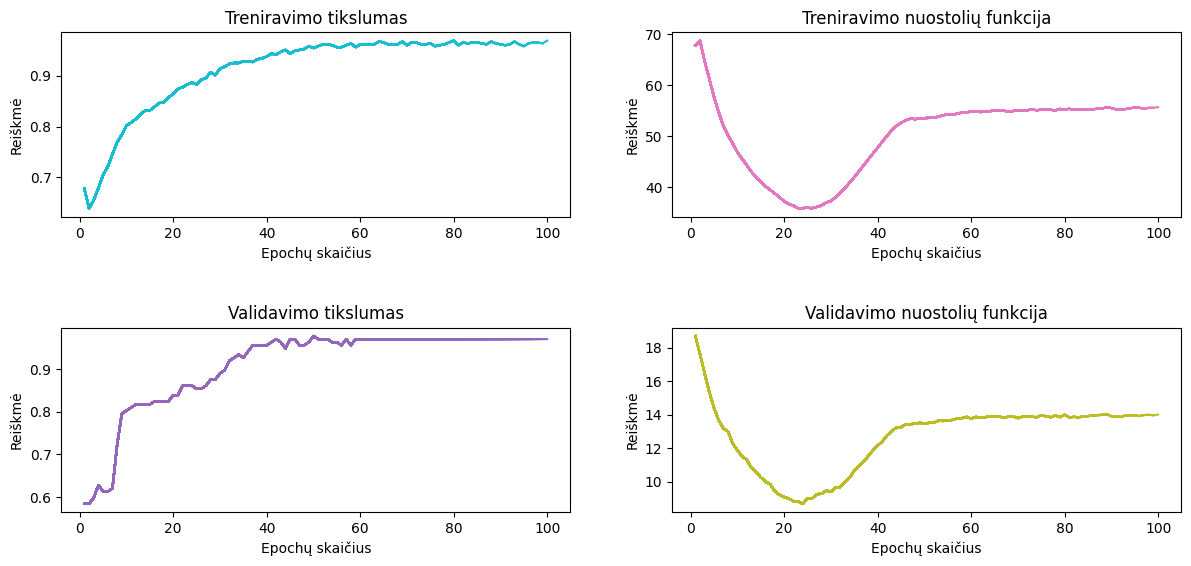

In [458]:
data = DataModule(feature_range=(1, 10), target_index= 10, filepath='Resources/breast-cancer-wisconsin.data')
model = Perceptron(activation_function= sigmoid_step_function, num_inputs = data.feature_count, learning_rate= 0.001)
trainer = Trainer()
trainer.train(model, data, epoch_count=100)

print('\n\nGalutiniai svoriai:', model.weights, '\n', 'Galutinis poslinkis:', model.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1])

Pradiniai svoriai:  [ 0.93622473 -0.86153998 -0.23038708 -0.66069167  0.14985278  0.00636569
  1.95345805  1.45950977  0.27520446] 
 Pradinis poslinkis:  0.46713776066448187


Galutiniai svoriai: [ 0.02622478 -0.00453989  0.01161304  0.01730836  0.02785281  0.02536566
  0.04745807  0.03250974  0.05620446] 
 Galutinis poslinkis: -0.670862239335519 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 10.0 
 Paskutinė (validavimo) tikslumo reikšmė: 0.9708029197080292


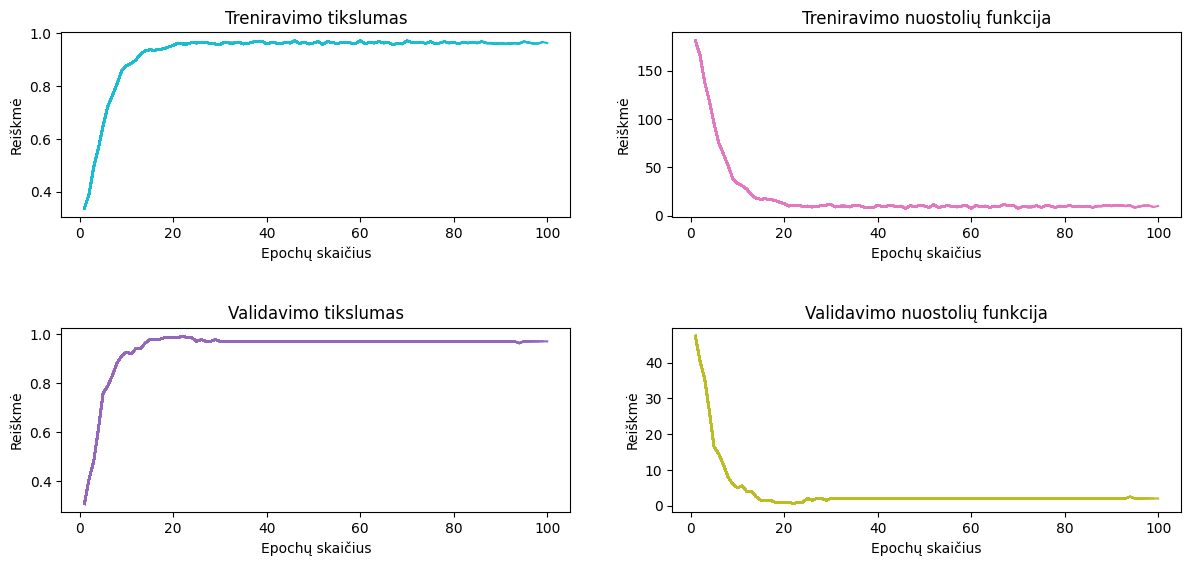

In [459]:
data = DataModule(feature_range=(1, 10), target_index= 10, filepath='Resources/breast-cancer-wisconsin.data')
model = Perceptron(activation_function= binary_step_function, num_inputs = data.feature_count, learning_rate= 0.001)
trainer = Trainer()
trainer.train(model, data, epoch_count=100)

print('\n\nGalutiniai svoriai:', model.weights, '\n', 'Galutinis poslinkis:', model.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1])

Pradiniai svoriai:  [ 0.20699086 -0.40653628  1.23281269 -0.46561128] 
 Pradinis poslinkis:  -1.5341783972702696


Galutiniai svoriai: [-0.20802783 -0.45251253  0.95054551 -0.22918041] 
 Galutinis poslinkis: -1.6255520186356132 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 6.661834082796448 
 Paskutinė (validavimo) tikslumo reikšmė: 0.9


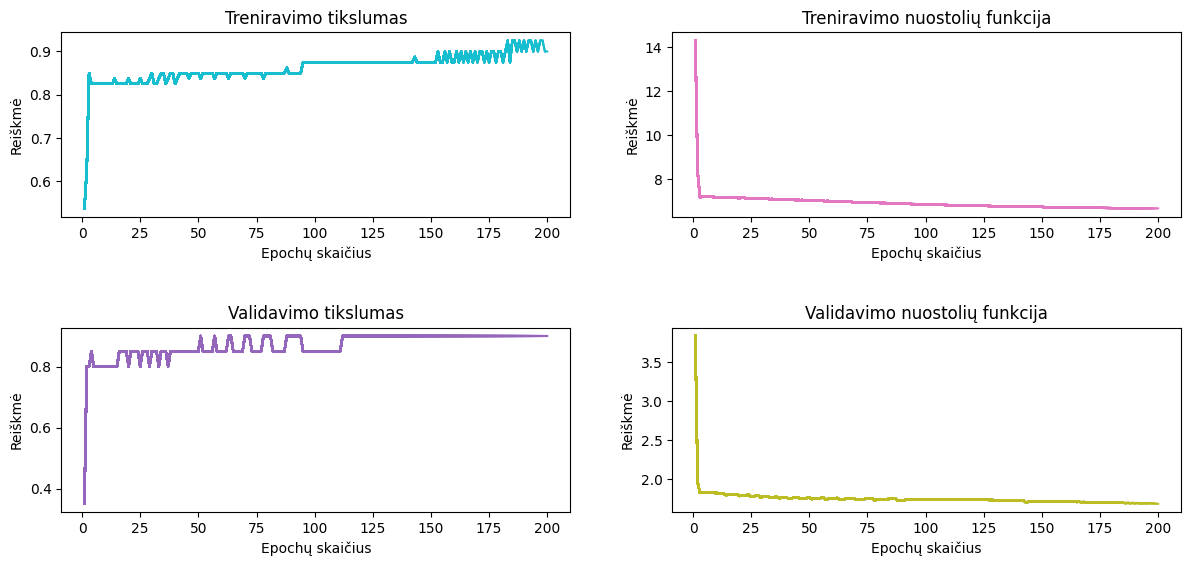

In [460]:
data = DataModule(feature_range=(0, 4), target_index= 4, filepath='Resources/iris.data')
model = Perceptron(activation_function= sigmoid_step_function, num_inputs = data.feature_count, learning_rate= 0.001)
trainer = Trainer()
trainer.train(model, data, epoch_count=200)

print('\n\nGalutiniai svoriai:', model.weights, '\n', 'Galutinis poslinkis:', model.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1])

Pradiniai svoriai:  [ 1.97907426  0.26810004  0.14528605 -0.48151545] 
 Pradinis poslinkis:  -0.9977505702187107


Galutiniai svoriai: [ 0.02037405 -0.21939999  0.270886    0.27698461] 
 Galutinis poslinkis: -1.2967505702186781 

 Paskutinė (treniravimo) nuostolių funkcijos reikšmė: 3.5 
 Paskutinė (validavimo) tikslumo reikšmė: 1.0


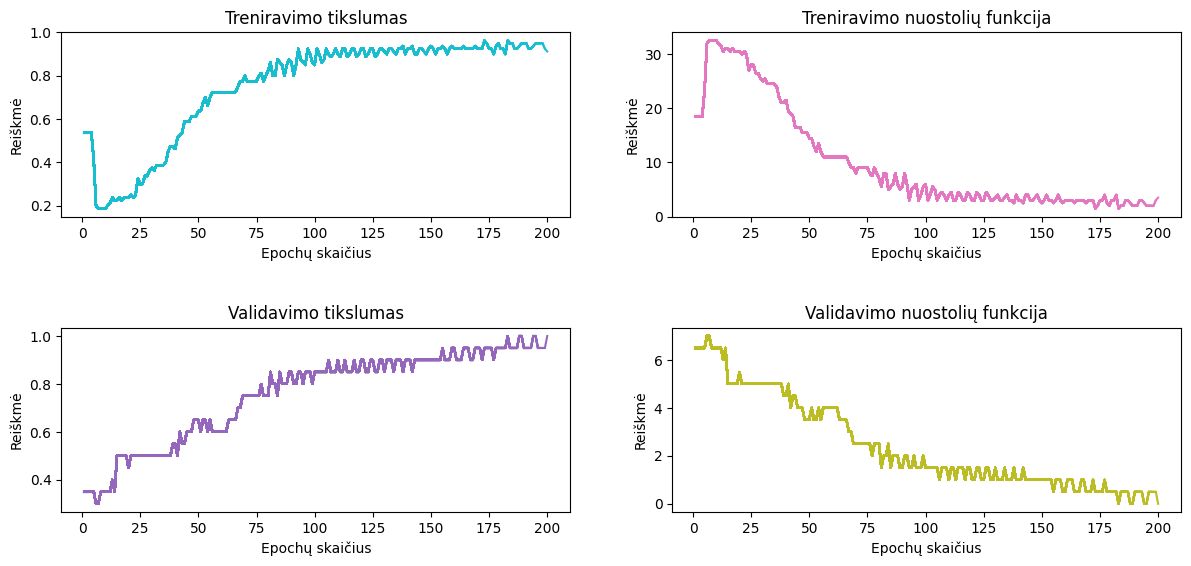

In [461]:
data = DataModule(feature_range=(0, 4), target_index= 4, filepath='Resources/iris.data')
model = Perceptron(activation_function= binary_step_function, num_inputs = data.feature_count, learning_rate= 0.001)
trainer = Trainer()
trainer.train(model, data, epoch_count=200)

print('\n\nGalutiniai svoriai:', model.weights, '\n', 'Galutinis poslinkis:', model.bias, '\n\n',
      'Paskutinė (treniravimo) nuostolių funkcijos reikšmė:', trainer.training_losses[-1], '\n',
      'Paskutinė (validavimo) tikslumo reikšmė:', trainer.validation_accuracies[-1])